<a href="https://colab.research.google.com/github/NusaibaTahsin328/Edge_Project_Nusaiba_2008007/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import glob
import re
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# User settings - tweak these to fit your data/sampling rate/preferences
PATH = "/content"  # folder where CSV files are stored in Colab
OUTPUT_DIR = "/content"
TRACKING_RATIO_THRESHOLD = 60.0   # minimum tracking quality percent to keep samples
VELOCITY_THRESHOLD_PX_S = 100.0   # px/s velocity threshold for fixation detection (I-VT)
MIN_FIXATION_DURATION_MS = 100    # minimum fixation duration to keep (ms)
INTERP_LIMIT = 5                  # max consecutive missing samples to interpolate
SPATIAL_P_LOW, SPATIAL_P_HIGH = 0.01, 0.99  # spatial percentile bounds for outlier removal


In [21]:
def find_best_column(cols, patterns):
    import re
    for pat in patterns:
        regex = re.compile(pat, re.IGNORECASE)
        for c in cols:
            if regex.search(c):
                return c
    return None

def choose_gaze_columns(all_cols):
    candidates = {}
    for side in ['right', 'left', '']:
        x_pat = rf'{side}.*(point of regard|por|gaze|eye position).*x'
        y_pat = rf'{side}.*(point of regard|por|gaze|eye position).*y'
        candidates['GazeX_{}'.format(side)] = find_best_column(all_cols, [x_pat, rf'{side}.*x'])
        candidates['GazeY_{}'.format(side)] = find_best_column(all_cols, [y_pat, rf'{side}.*y'])
    gx_priority = [candidates.get('GazeX_right'), candidates.get('GazeX_any'),
                   candidates.get('GazeX_left')]
    gy_priority = [candidates.get('GazeY_right'), candidates.get('GazeY_any'),
                   candidates.get('GazeY_left')]
    # Also generic
    gx_any = find_best_column(all_cols, [r'point of regard.*x', r'por.*x', r'gaze.*x'])
    gy_any = find_best_column(all_cols, [r'point of regard.*y', r'por.*y', r'gaze.*y'])
    gx_priority.insert(1, gx_any)
    gy_priority.insert(1, gy_any)

    gx = next((c for c in gx_priority if c), None)
    gy = next((c for c in gy_priority if c), None)
    return gx, gy

def choose_pupil_columns(all_cols):
    patterns = [r'pupil.*diameter', r'pupil size', r'pupil.*mm', r'pupil.*diam']
    right = find_best_column(all_cols, [r'right.*' + p for p in patterns] + [r'pupil.*right'])
    left  = find_best_column(all_cols,  [r'left.*' + p for p in patterns] + [r'pupil.*left'])
    anyp  = find_best_column(all_cols, patterns)
    return right, left, anyp

def choose_time_col(all_cols):
    return find_best_column(all_cols, [r'recordingtime', r'recording time', r'recording.*ms', r'time\s*\[ms\]', r'time.*ms', r'^time$'])

def choose_tracking_ratio_col(all_cols):
    return find_best_column(all_cols, [r'tracking ratio', r'tracking.*%?', r'tracking_quality', r'valid.*samples'])

def choose_participant_col(all_cols):
    return find_best_column(all_cols, [r'participant', r'subject', r'user', r'id\b'])

def choose_trial_col(all_cols):
    return find_best_column(all_cols, [r'\btrial\b', r'trial id', r'trialnumber', r'trial\s*\['])

def choose_aoi_cols(all_cols):
    aoi = find_best_column(all_cols, [r'\bAOI\b', r'aoi name', r'aoi', r'area of interest'])
    aoi_r = find_best_column(all_cols, [r'aoi.*right', r'aoi name right'])
    aoi_l = find_best_column(all_cols, [r'aoi.*left', r'aoi name left'])
    return aoi, aoi_r, aoi_l


In [25]:
csv_files = sorted(glob.glob(os.path.join(PATH, "*.csv")),
                   key=lambda x: (0, int(os.path.splitext(os.path.basename(x))[0]))
                   if os.path.splitext(os.path.basename(x))[0].isdigit()
                   else (1, os.path.splitext(os.path.basename(x))[0]))

if len(csv_files) == 0:
    raise SystemExit(f"No CSV files found in PATH={PATH}. Upload files or change PATH.")

print(f"Found {len(csv_files)} CSV files (showing first 10):\n", csv_files[:10])

col_counter = Counter()
file_columns = {}
for f in csv_files:
    try:
        df_head = pd.read_csv(f, nrows=1, low_memory=False)
        cols = list(df_head.columns)
        file_columns[f] = cols
        col_counter.update(cols)
    except Exception as e:
        print(f"Error reading header of {f}:", e)
        file_columns[f] = []

print("\nMost common columns across files:")
for col, cnt in col_counter.most_common(30):
    print(f"{cnt:3}  {col}")

all_cols = list({c for cols in file_columns.values() for c in cols})

GazeX_col, GazeY_col = choose_gaze_columns(all_cols)
PupilR_col, PupilL_col, Pupil_any = choose_pupil_columns(all_cols)
time_col = choose_time_col(all_cols)
tracking_col = choose_tracking_ratio_col(all_cols)
participant_col = choose_participant_col(all_cols)
trial_col = choose_trial_col(all_cols)
AOI_col, AOI_r_col, AOI_l_col = choose_aoi_cols(all_cols)

print("\nDetected columns (best guesses):")
print(" time_col:", time_col)
print(" participant:", participant_col)
print(" trial:", trial_col)
print(" gaze X:", GazeX_col)
print(" gaze Y:", GazeY_col)
print(" pupil right:", PupilR_col, " pupil left:", PupilL_col, " pupil any:", Pupil_any)
print(" tracking ratio:", tracking_col)
print(" AOI / AOI right / AOI left:", AOI_col, AOI_r_col, AOI_l_col)

Found 28 CSV files (showing first 10):
 ['/content/1.csv', '/content/2.csv', '/content/3.csv', '/content/4.csv', '/content/5.csv', '/content/6.csv', '/content/7.csv', '/content/8.csv', '/content/9.csv', '/content/10.csv']

Most common columns across files:
 26  Unnamed: 0
 26  RecordingTime [ms]
 26  Time of Day [h:m:s:ms]
 26  Trial
 26  Stimulus
 26  Export Start Trial Time [ms]
 26  Export End Trial Time [ms]
 26  Participant
 26  Color
 26  Tracking Ratio [%]
 26  Category Group
 26  Category Right
 26  Index Right
 26  Point of Regard Right X [px]
 26  Point of Regard Right Y [px]
 26  Gaze Vector Right X
 26  Gaze Vector Right Y
 26  Gaze Vector Right Z
 26  Annotation Name
 26  Annotation Description
 26  Annotation Tags
 26  Mouse Position X [px]
 26  Mouse Position Y [px]
 26  Scroll Direction X
 26  Scroll Direction Y
 26  Content
 25  AOI Name Right
 24  Category Left
 24  Index Left
 24  Point of Regard Left X [px]

Detected columns (best guesses):
 time_col: RecordingTime 

In [5]:
# path where your CSVs are (default Colab working dir)
path = "/content"

# get csv file list (assumes names like 1.csv, 2.csv ...)
csv_files = sorted(glob.glob(os.path.join(path, "*.csv")),
                   key=lambda x: int(os.path.basename(x).split(".")[0]) if os.path.basename(x).split(".")[0].isdigit() else x)

print(f"Found {len(csv_files)} CSV files. First 10:\n", csv_files[:10])


Found 25 CSV files. First 10:
 ['/content/1.csv', '/content/2.csv', '/content/3.csv', '/content/4.csv', '/content/5.csv', '/content/6.csv', '/content/7.csv', '/content/8.csv', '/content/9.csv', '/content/10.csv']


In [6]:
dfs = []
for f in tqdm(csv_files, desc="Reading CSVs"):
    try:
        df = pd.read_csv(f, low_memory=False)   # low_memory=False avoids dtype warnings
        df['source_file'] = os.path.basename(f)
        dfs.append(df)
    except Exception as e:
        print("Error reading", f, ":", e)

if len(dfs)==0:
    raise SystemExit("No files loaded - check file paths or uploads.")

full = pd.concat(dfs, ignore_index=True)
print("Combined shape:", full.shape)
full.head()


Reading CSVs: 100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Combined shape: (2252943, 60)


,Unnamed: 0,RecordingTime [ms],Time of Day [h:m:s:ms],Trial,Stimulus,Export Start Trial Time [ms],Export End Trial Time [ms],Participant,Color,Tracking Ratio [%],...,Pupil Position Left X [px],Pupil Position Left Y [px],Port Status,AOI Group Right,AOI Scope Right,AOI Order Right,AOI Group Left,AOI Scope Left,AOI Order Binocular,groupe d'enfants
0,0,4780015.315,13:22:17:254,Trial020,20 eye tracking (ballon droite).avi,0.0,52058.676,50,Coral,78.5652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4780020.865,13:22:17:260,Trial020,20 eye tracking (ballon droite).avi,0.0,52058.676,50,Coral,78.5652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4780040.758,13:22:17:279,Trial020,20 eye tracking (ballon droite).avi,0.0,52058.676,50,Coral,78.5652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4780080.503,13:22:17:319,Trial020,20 eye tracking (ballon droite).avi,0.0,52058.676,50,Coral,78.5652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4780120.360,13:22:17:359,Trial020,20 eye tracking (ballon droite).avi,0.0,52058.676,50,Coral,78.5652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# See columns and a quick summary
print("Columns:", list(full.columns))
print("\nSample info:")
display(full[['RecordingTime [ms]','Participant','Trial','Stimulus','Tracking Ratio [%]']].head())

# Convert RecordingTime to numeric if needed and create seconds column
full['RecordingTime [ms]'] = pd.to_numeric(full['RecordingTime [ms]'], errors='coerce')
full = full.dropna(subset=['RecordingTime [ms]'])
full['time_s'] = full['RecordingTime [ms]'] / 1000.0


Columns: ['Unnamed: 0', 'RecordingTime [ms]', 'Time of Day [h:m:s:ms]', 'Trial', 'Stimulus', 'Export Start Trial Time [ms]', 'Export End Trial Time [ms]', 'Participant', 'Color', 'Tracking Ratio [%]', 'Category Group', 'Category Right', 'Category Left', 'Index Right', 'Index Left', 'Pupil Diameter Right [mm]', 'Pupil Diameter Left [mm]', 'Point of Regard Right X [px]', 'Point of Regard Right Y [px]', 'Point of Regard Left X [px]', 'Point of Regard Left Y [px]', 'AOI Name Right', 'AOI Name Left', 'Gaze Vector Right X', 'Gaze Vector Right Y', 'Gaze Vector Right Z', 'Gaze Vector Left X', 'Gaze Vector Left Y', 'Gaze Vector Left Z', 'Annotation Name', 'Annotation Description', 'Annotation Tags', 'Mouse Position X [px]', 'Mouse Position Y [px]', 'Scroll Direction X', 'Scroll Direction Y', 'Content', 'source_file', 'Pupil Size Right X [px]', 'Pupil Size Right Y [px]', 'Pupil Size Left X [px]', 'Pupil Size Left Y [px]', 'Eye Position Right X [mm]', 'Eye Position Right Y [mm]', 'Eye Position Ri

,RecordingTime [ms],Participant,Trial,Stimulus,Tracking Ratio [%]
0,4780015.315,50,Trial020,20 eye tracking (ballon droite).avi,78.5652
1,4780020.865,50,Trial020,20 eye tracking (ballon droite).avi,78.5652
2,4780040.758,50,Trial020,20 eye tracking (ballon droite).avi,78.5652
3,4780080.503,50,Trial020,20 eye tracking (ballon droite).avi,78.5652
4,4780120.360,50,Trial020,20 eye tracking (ballon droite).avi,78.5652


In [8]:
# Treat 0 or unrealistic 0.0 as missing for the point-of-regard columns
for c in ['Point of Regard Right X [px]', 'Point of Regard Right Y [px]',
          'Point of Regard Left X [px]',  'Point of Regard Left Y [px]']:
    if c in full.columns:
        full[c] = pd.to_numeric(full[c], errors='coerce')
        full.loc[full[c] == 0, c] = np.nan   # convert zero values to NaN (common export behavior)

# Create unified gaze coordinates by preferring right eye, falling back to left eye
full['GazeX'] = full['Point of Regard Right X [px]'].combine_first(full['Point of Regard Left X [px]'])
full['GazeY'] = full['Point of Regard Right Y [px]'].combine_first(full['Point of Regard Left Y [px]'])

# Pupil: average of left & right where available (and treat 0 -> NaN)
for pcol in ['Pupil Diameter Right [mm]', 'Pupil Diameter Left [mm]']:
    if pcol in full.columns:
        full[pcol] = pd.to_numeric(full[pcol], errors='coerce')
        full.loc[full[pcol] == 0, pcol] = np.nan

full['Pupil'] = full[['Pupil Diameter Right [mm]','Pupil Diameter Left [mm]']].mean(axis=1)


In [9]:
TRACKING_RATIO_THRESHOLD = 60.0   # percent

if 'Tracking Ratio [%]' in full.columns:
    full['Tracking Ratio [%]'] = pd.to_numeric(full['Tracking Ratio [%]'], errors='coerce')
    before = len(full)
    full = full[ full['Tracking Ratio [%]'].fillna(0) >= TRACKING_RATIO_THRESHOLD ]
    print(f"Removed {before - len(full)} rows below tracking ratio {TRACKING_RATIO_THRESHOLD}%")

# Drop rows missing unified gaze coords
before = len(full)
full = full.dropna(subset=['GazeX','GazeY'])
print(f"Removed {before - len(full)} rows without GazeX/GazeY.")


Removed 546105 rows below tracking ratio 60.0%
Removed 143569 rows without GazeX/GazeY.


In [10]:
# Use 0.5%-99.5% or 1%-99% to cut extreme outliers
p_low, p_high = 0.01, 0.99
x_low, x_high = full['GazeX'].quantile(p_low), full['GazeX'].quantile(p_high)
y_low, y_high = full['GazeY'].quantile(p_low), full['GazeY'].quantile(p_high)

mask = (full['GazeX'] >= x_low) & (full['GazeX'] <= x_high) & (full['GazeY'] >= y_low) & (full['GazeY'] <= y_high)
print("Keeping {} / {} rows after spatial bounds filter.".format(mask.sum(), len(full)))
full = full[mask].copy()


Keeping 1503375 / 1563269 rows after spatial bounds filter.


In [11]:
full = full.sort_values(['Participant','Trial','time_s']).reset_index(drop=True)

# Estimate median sampling interval per participant or global
full['dt'] = full.groupby(['Participant','Trial'])['time_s'].diff()
median_dt = full['dt'].median()
print("Estimated median dt (s):", median_dt)
print("Approx sample rate (Hz):", 1/(median_dt if median_dt>0 else np.nan))


Estimated median dt (s): 0.01669400000037058
Approx sample rate (Hz): 59.90176111044697


In [12]:
# interpolate GazeX, GazeY, Pupil for small consecutive gaps for each trial
def interp_group(g):
    g = g.set_index('time_s').sort_index()
    # linear interpolate numeric columns
    g[['GazeX','GazeY','Pupil']] = g[['GazeX','GazeY','Pupil']].interpolate(method='linear', limit=5)  # limit controls max consecutive NaNs to fill
    return g.reset_index()

full = full.groupby(['Participant','Trial'], group_keys=False).apply(interp_group).reset_index(drop=True)


/tmp/ipython-input-557963336.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full = full.groupby(['Participant','Trial'], group_keys=False).apply(interp_group).reset_index(drop=True)


In [13]:
# compute euclidean distance and velocity per trial
def compute_velocity(g):
    g = g.sort_values('time_s')
    g['dx'] = g['GazeX'].diff()
    g['dy'] = g['GazeY'].diff()
    g['dt'] = g['time_s'].diff()
    g['dist_px'] = np.sqrt(g['dx'].fillna(0)**2 + g['dy'].fillna(0)**2)
    g['vel_px_s'] = g['dist_px'] / g['dt'].replace({0:np.nan})
    return g

full = full.groupby(['Participant','Trial'], group_keys=False).apply(compute_velocity).reset_index(drop=True)

# Simple threshold-based fixation: velocity below threshold -> fixation sample
VELOCITY_THRESHOLD_PX_S = 100.0   # tune this for your data
full['is_fixation_sample'] = (full['vel_px_s'].fillna(0) <= VELOCITY_THRESHOLD_PX_S).astype(int)

# Group consecutive fixation samples into fixation events
def label_fixations(g):
    g = g.copy()
    g['fix_group'] = (g['is_fixation_sample'] != g['is_fixation_sample'].shift(1)).cumsum()
    # keep only fixation groups where is_fixation_sample==1
    fix_groups = g[g['is_fixation_sample']==1].groupby('fix_group')
    records = []
    for ig, sub in fix_groups:
        duration_ms = (sub['RecordingTime [ms]'].iloc[-1] - sub['RecordingTime [ms]'].iloc[0])
        records.append({
            'participant': sub['Participant'].iloc[0],
            'trial': sub['Trial'].iloc[0],
            'fix_group': ig,
            'start_time_s': sub['time_s'].iloc[0],
            'end_time_s': sub['time_s'].iloc[-1],
            'duration_ms': duration_ms,
            'mean_x': sub['GazeX'].mean(),
            'mean_y': sub['GazeY'].mean()
        })
    return pd.DataFrame.from_records(records)

fixations_df = full.groupby(['Participant','Trial'], group_keys=False).apply(label_fixations).reset_index(drop=True)
print("Total fixations found:", len(fixations_df))


/tmp/ipython-input-2678800608.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full = full.groupby(['Participant','Trial'], group_keys=False).apply(compute_velocity).reset_index(drop=True)


Total fixations found: 280594


/tmp/ipython-input-2678800608.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fixations_df = full.groupby(['Participant','Trial'], group_keys=False).apply(label_fixations).reset_index(drop=True)


In [14]:
MIN_FIXATION_DURATION_MS = 100  # only keep fixations >= 100 ms
fixations_df = fixations_df[fixations_df['duration_ms'] >= MIN_FIXATION_DURATION_MS].copy()

# aggregate features per (participant,trial)
fix_agg = fixations_df.groupby(['participant','trial']).agg(
    fixation_count = ('fix_group','nunique'),
    mean_fixation_dur_ms = ('duration_ms','mean'),
    total_fixation_time_ms = ('duration_ms','sum')
).reset_index()

# Compute other trial-level features from sampled data
trial_stats = full.groupby(['Participant','Trial']).agg(
    gaze_x_mean = ('GazeX','mean'),
    gaze_y_mean = ('GazeY','mean'),
    gaze_x_std  = ('GazeX','std'),
    gaze_y_std  = ('GazeY','std'),
    pupil_mean  = ('Pupil','mean'),
    pupil_std   = ('Pupil','std'),
    median_vel  = ('vel_px_s','median'),
    samples     = ('GazeX','count')
).reset_index().rename(columns={'Participant':'participant','Trial':'trial'})

# Merge fixations features
features = pd.merge(trial_stats, fix_agg, how='left', left_on=['participant','trial'], right_on=['participant','trial']).fillna(0)
features.head()


,participant,trial,gaze_x_mean,gaze_y_mean,gaze_x_std,gaze_y_std,pupil_mean,pupil_std,median_vel,samples,fixation_count,mean_fixation_dur_ms,total_fixation_time_ms
0,11,Trial001,800.196761,557.152389,231.988297,137.007260,3.969641,0.432051,863.015258,515,0.0,0.0,0.0
1,11,Trial002,612.395707,630.133283,102.914090,170.637051,3.727825,0.195272,768.881113,206,0.0,0.0,0.0
2,11,Trial003,758.389895,709.411832,205.762438,195.174290,3.569284,0.198341,447.733144,552,0.0,0.0,0.0
3,11,Trial004,392.030420,580.457833,242.897832,107.882077,3.344080,0.199393,476.725190,192,0.0,0.0,0.0
4,11,Trial005,650.795483,455.443573,257.640449,121.496031,3.915080,0.376804,420.930820,562,0.0,0.0,0.0


In [15]:
# If AOI Name Right / AOI Name Left exist, combine them similarly to gaze
if 'AOI Name Right' in full.columns or 'AOI Name Left' in full.columns:
    full['AOI'] = full['AOI Name Right'].fillna(full.get('AOI Name Left'))
    aoi_counts = full.groupby(['Participant','Trial'])['AOI'].value_counts().unstack(fill_value=0).reset_index()
    # Merge aoi counts into features (by matching column names)
    # rename columns so they merge easily
    aoi_counts = aoi_counts.rename(columns={'Participant':'participant','Trial':'trial'})
    features = features.merge(aoi_counts, how='left', on=['participant','trial'])
    features.fillna(0, inplace=True)


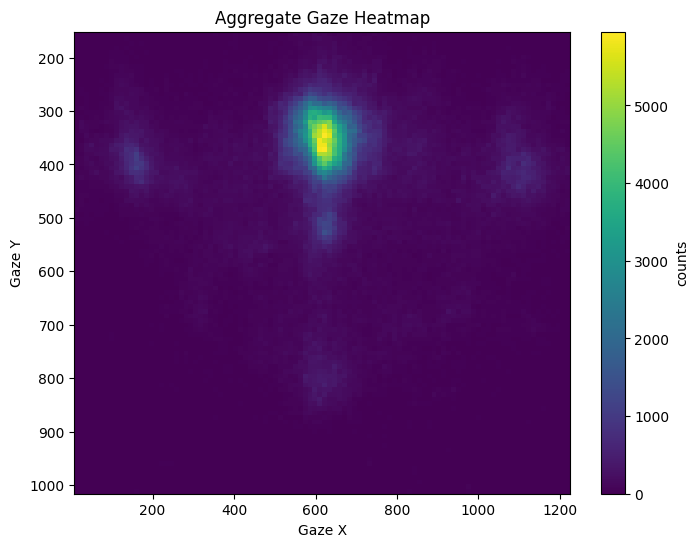

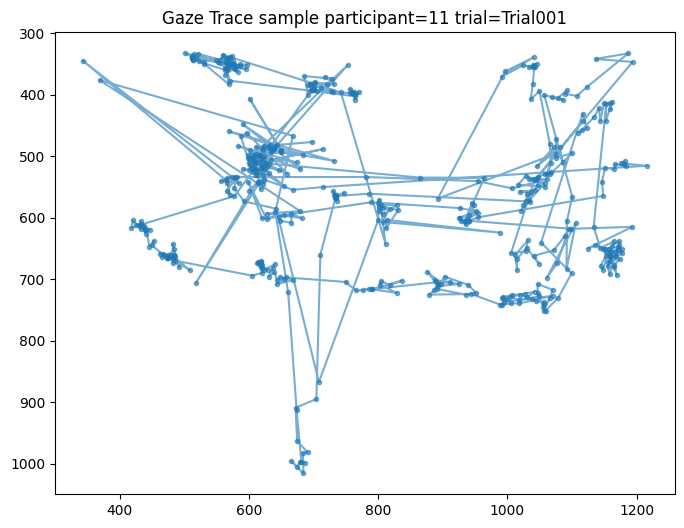

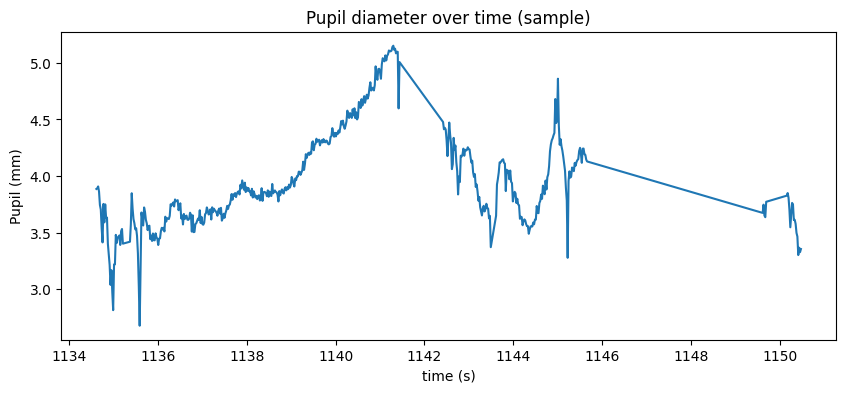

In [16]:
# Heatmap of all gaze points (right now combined)
plt.figure(figsize=(8,6))
plt.hist2d(full['GazeX'], full['GazeY'], bins=100)
plt.gca().invert_yaxis()
plt.title("Aggregate Gaze Heatmap")
plt.xlabel("Gaze X")
plt.ylabel("Gaze Y")
plt.colorbar(label='counts')
plt.show()

# Plot one participant/trial gaze trace (pick one)
sample = full[(full['Participant'] == full['Participant'].iloc[0]) & (full['Trial'] == full['Trial'].iloc[0])]
plt.figure(figsize=(8,6))
plt.plot(sample['GazeX'], sample['GazeY'], '-o', markersize=3, alpha=0.6)
plt.gca().invert_yaxis()
plt.title(f"Gaze Trace sample participant={sample['Participant'].iloc[0]} trial={sample['Trial'].iloc[0]}")
plt.show()

# Pupil over time for that sample
plt.figure(figsize=(10,4))
plt.plot(sample['time_s'], sample['Pupil'])
plt.xlabel('time (s)')
plt.ylabel('Pupil (mm)')
plt.title('Pupil diameter over time (sample)')
plt.show()


In [17]:
full.to_csv('/content/preprocessed_combined.csv', index=False)
features.to_csv('/content/trial_features.csv', index=False)
fixations_df.to_csv('/content/fixations.csv', index=False)
print("Saved: preprocessed_combined.csv, trial_features.csv, fixations.csv")


Saved: preprocessed_combined.csv, trial_features.csv, fixations.csv
